<a href="https://colab.research.google.com/github/nedokormysh/Stepik_Ai_edu_RNN/blob/week_6_Word_RNN_Classification/AiEdu_WordRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация последовательностей (текстов) при помощи RNN

На прошлом семинаре мы рассмотрели пример генерации текстов при помощи CharRnn. Однако мы не обсудили весь огромный функционал, который предоставляет пайторч для работы с текстами. В частности работали мы с посимвольной генерацией, а не пословной/потокенной. Исправляемся!

Сегодня речь зайдёт о задаче классификации текстовых последовательностей. Для этого будем пользоваться датасетом IMDB (датасет содержит отзывы на фильмы, и необходимо определить их тональность - позитивные или негативные) и библиотекой `torchtext`. В торчтексте реализовано огромное число методов для обработки текстов, ими мы и воспользуемся.

__ВАЖНО__. Торчтекст не рекомендуется использовать для обучения на больших данных (от миллиона примеров и больше) из-за маленькой скорости работы. В таких случаях рекомендуется имплементировать свои датасеты. В наших примерах таких объёмов данных не будет.

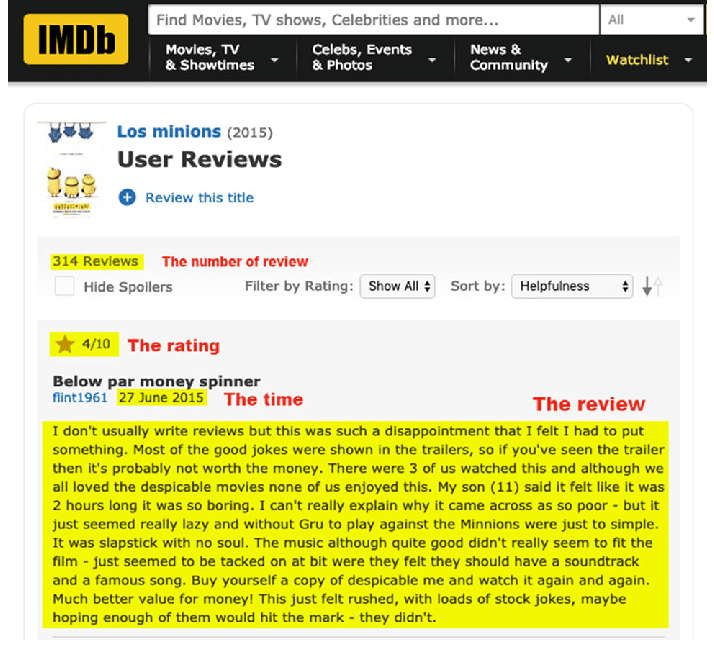

## Начнём с модели.

Да, не самая привычная последовательность действий, но давайте сначала сделаем кое-что, с чем мы уже знакомы -- имплементируем модель.

На вход она будет принимать батч последовательностей токенов, разумеется разной длины в разных батчах, а на выходе выдавать батч вероятностей классов, прямо как в классификации картинок.

Каждый токен пройдёт вначале через эмбеддинг, а затем последовательность эмбеддингов пройдёт через LSTM. Самое последнее скрытое состояние будем считать векторным представлением для последовательности, поверх неё мы навесим линейный слой.

In [ ]:
import pandas as pd
import torch
from torch import nn


class TextClassifier(nn.Module):
    def __init__(
        self,
        num_embeddings=25002,
        embedding_size=300,
        hidden_size=200,
        num_classes=2,
        num_layers=1,
    ):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_size) # vocab_size, embedding_dim
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (last_hidden, last_c) = self.lstm(embedded)
        return self.linear(last_hidden[0]).squeeze()


model = TextClassifier()

In [ ]:
model(torch.tensor([[1, 2, 3, 4], [1, 2, 3, 4]]))

tensor([-0.0195, -0.0195], grad_fn=<SqueezeBackward0>)

## Скачаем и проинициализируем датасет

Дальше перейдём к торчтексту. Он почти как знакомый нам `torchvision` имеет внутри себя коллекцию датасетов для разных задач NLP в том числе и отзывы на IMDB. Инициализация датасета порой занимает время, не следует волноваться и судорожно перезапускать ядро.

In [ ]:
!pip show torchtext

Name: torchtext
Version: 0.6.0
Summary: Text utilities and datasets for PyTorch
Home-page: https://github.com/pytorch/text
Author: PyTorch core devs and James Bradbury
Author-email: jekbradbury@gmail.com
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, requests, sentencepiece, six, torch, tqdm
Required-by: 


In [ ]:
!pip install torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.7 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled torchtext-0.16.0


In [ ]:
import torchtext
from torchtext import data
from torchtext.datasets import IMDB

In [ ]:
# spacy -- вспомогательная библоитека для токенизации текста, скачаем токенайзер для английского языка
! pip install spacy
! python -m spacy download en_core_web_sm

2024-01-20 08:38:36.894430: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-20 08:38:36.894486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-20 08:38:36.895789: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-20 08:38:36.902947: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-20 08:38:37.951274: W tensorflow/compiler/tf2

В `torchtext` существует такая сущность, как `Field`. Это просто класс, в котором содержится описание колонок нашего датасета. В нашем случае всё довольно просто. Есть две колонки --- это текст и оценка, назовём их `text_field` и `label_field` соответственно. Токенизовать будем при помощи установленной только что библиотеки `spacy`, лейблы приведём к типу `float`. Как и на прошлом семинаре ставим `batch_first = False`.

Преимущества токенизатора SpaCy:

* SpaCy использует продвинутые правила токенизации, учитывая контекст и особенности языка. Это позволяет ему более точно разбивать текст на токены, учитывая сложные случаи, такие как аббревиатуры, дефисы, сокращения и др.

* Стандартные токенизаторы могут предоставлять базовую функциональность, но они могут не учитывать сложные языковые конструкции и требовать дополнительной настройки.

In [ ]:
from torchtext.data import Field, LabelField

In [ ]:
text_field = Field(
    tokenize="spacy",
    batch_first=True,
    include_lengths=False,
    tokenizer_language="en_core_web_sm",
)

label_field = LabelField(dtype=torch.float32, batch_first=True)

Создадим два сплита нашего датасета. Они задаются при помощи метода splits.

In [ ]:
data_train, data_test = IMDB.splits(text_field, label_field)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:02<00:00, 29.7MB/s]


Создадим также словари, соответствующие нашему тексту. Выкинем все слова (токены), которые встречаются редко. Оставим только 25 тысяч самых частых слов.

Также согласуем номера токенов в словаре с эмбеддингами glove. При желании можно согласовать и с word2vec'ом, но имейте ввиду, что glove это их аналог. Об инициализации эмбеддингов мы обязательно поговорим чуть позже.

In [ ]:
vocab_size = 25000

# build_vocab -- создать словарь по данному полю в датасете
text_field.build_vocab(
    data_train,
    max_size=vocab_size,
    vectors="glove.6B.100d",
)

label_field.build_vocab(data_train)

for item in data_train:
    print(item.text)
    break

.vector_cache/glove.6B.zip: 862MB [02:39, 5.41MB/s]                           
100%|█████████▉| 399999/400000 [00:21<00:00, 18408.05it/s]


['PRC', 'which', 'was', 'the', 'lowest', 'of', 'the', 'low', 'actually', 'struck', 'gold', 'with', 'this', 'moody', 'little', 'thriller', '.', 'They', 'did', 'the', 'same', 'thing', 'a', 'year', 'earlier', 'with', '"', 'Detour', '"', 'which', 'is', 'probably', 'one', 'of', 'the', 'finest', 'low', '-', 'budget', 'films', 'ever', 'made.<br', '/><br', '/>"Strangler', '"', 'is', 'basically', 'a', 'one', 'set', 'film', ',', 'filled', 'with', 'mist', 'and', 'shadows', ',', 'a', 'technique', 'used', 'by', 'most', 'poverty', 'row', 'studios', 'to', 'hide', 'the', 'sets', ',', 'or', 'lack', 'thereof', '.', 'But', 'here', ',', 'it', 'works', 'well', '.', 'The', 'ghost', 'of', 'Charles', 'Middleton', '(', 'better', 'known', 'as', 'Ming', 'the', 'Merciless', ')', 'lurches', 'around', 'the', 'swamp', 'killing', 'those', 'involved', 'in', 'his', 'wrongful', 'execution', 'for', 'murder', 'and', 'generates', 'some', 'sympathy', 'from', 'the', 'viewer', '.', 'His', 'final', 'victim', 'is', 'to', 'be', 

Давайте посмотрим на самые частые токены в словаре.

In [ ]:
text_field.vocab.freqs.most_common(10)

[('the', 289838),
 (',', 275296),
 ('.', 236709),
 ('and', 156484),
 ('a', 156282),
 ('of', 144056),
 ('to', 133886),
 ('is', 109095),
 ('in', 87676),
 ('I', 77546)]

In [ ]:
# itos -- index to string
text_field.vocab.itos[:10]

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']

Как мы видим, в поле текста у нас стоят токены, на которые SpaCy поделил текст! Осталось только воспользоваться построенным словарём и сделать аналог даталоадера по данным!

In [ ]:
train_dataloader, test_dataloader = data.BucketIterator.splits(
    (data_train, data_test), batch_size=32, device="cuda:0"
)

In [ ]:
for item in train_dataloader:
    print(item.text.shape, item.label.shape)
    break

torch.Size([32, 1827]) torch.Size([32])


Длина текста около 1000 символов это очень много для нашей маленькой модельки. Будем обрезать их на 256 токенах в нашем трейн лупе.

## Train loop

Перейдём к самому интересному и построим train loop к нашей модели. Но скажем сразу, он мало чем будет отличаться от классификации картинок.

In [ ]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    criterion,
    return_losses=False,
    device="cuda:0",
):
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])  # .reshape((0, ))
    total_labels = np.array([])  # .reshape((0, ))

    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for item in data_loader:
            reviews = item.text
            labels = item.label

            # Move Batch to GPU
            reviews = reviews.to(device)
            labels = labels.to(device)
            predicted = model(reviews)
            loss = criterion(predicted, labels)

            # Update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Update descirption for tqdm
            accuracy = ((predicted > 0.5).int() == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(
                total_predictions, (predicted > 0.5).int().cpu().detach().numpy()
            )
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())

    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def validate(model, data_loader, criterion, device="cuda:0"):

    model = model.eval()
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])

    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for reviews, labels in data_loader:
            reviews = reviews.to(device)
            labels = labels.to(device)
            predicted = model(reviews)

            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()

            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(
                total_predictions, predicted.argmax(1).cpu().detach().numpy()
            )
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1

    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    return metrics

In [ ]:
import sys

import numpy as np
from tqdm.notebook import tqdm

device = "cuda:0"
model = TextClassifier()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

for i in range(10):
    train_epoch(
        model, train_dataloader, criterion=criterion, optimizer=optimizer, device=device
    )

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

Кажется, обучается так себе. Давайте это исправлять!

Попробуем сделать следующее:

* сделаем модель двунаправленной

* добавим DropOut

* инициализируем эмбеддинги GloVe векторами

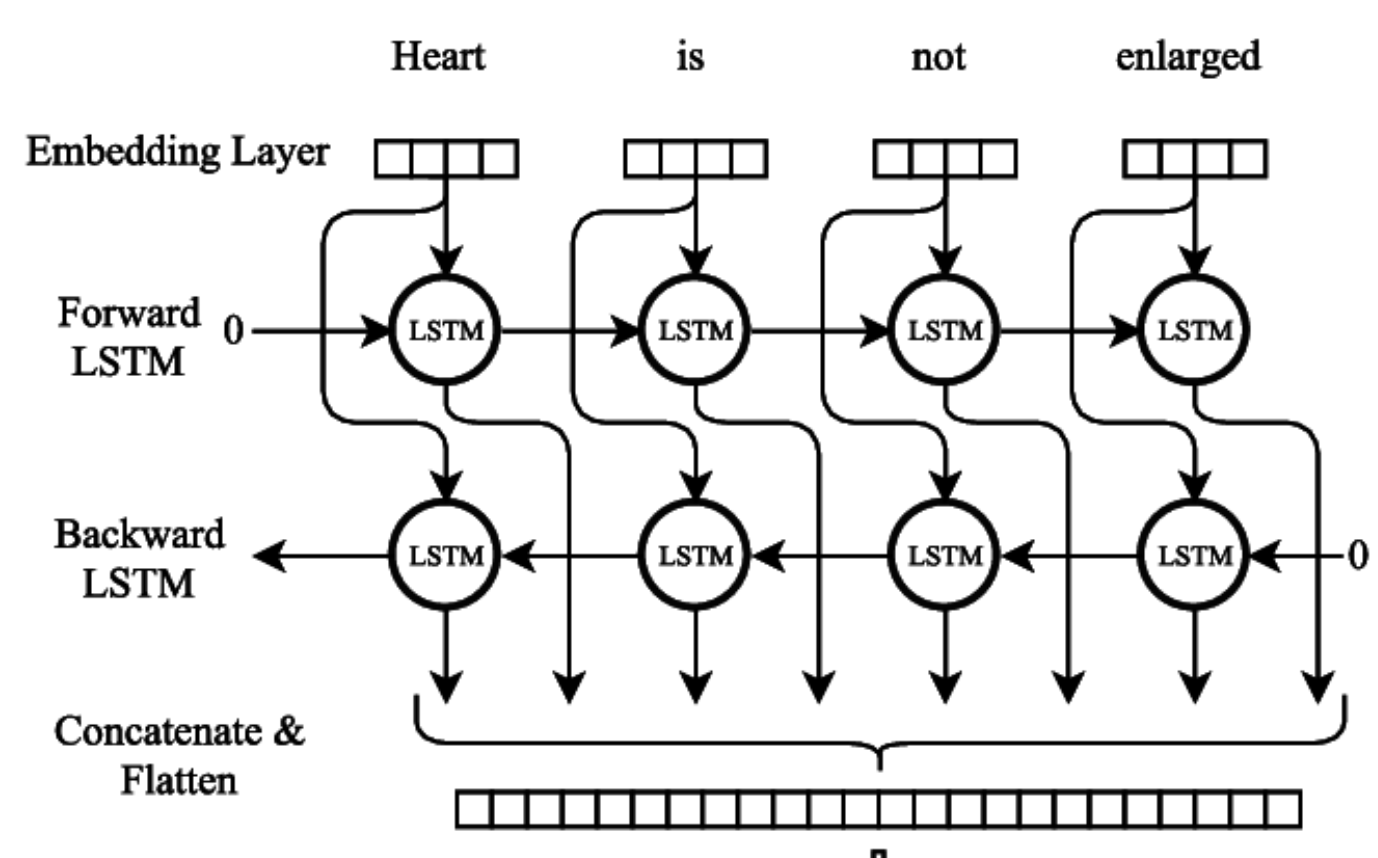

In [ ]:
class TextClassifier(nn.Module):
    def __init__(
        self,
        num_embeddings=25002,
        embedding_size=300,
        hidden_size=200,
        num_classes=2,
        num_layers=1,
        pad_token=1,
    ):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(
            num_embeddings, embedding_size, padding_idx=pad_token
        )
        self.lstm = nn.LSTM(
            embedding_size,
            hidden_size,
            batch_first=True,
            num_layers=num_layers,
            bidirectional=True,
        )
        self.linear = nn.Linear(hidden_size * num_layers, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        _, (last_hidden, last_c) = self.lstm(embedded)
        hidden = torch.cat([last_hidden[-2], last_hidden[-1]], dim=1)
        return self.linear(hidden).squeeze()


device = "cuda:0"
pad_token = text_field.vocab.stoi["<pad>"]
model = TextClassifier(
    hidden_size=512, embedding_size=100, num_layers=2, pad_token=pad_token
)
model.embedding.weight.data = text_field.vocab.vectors

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.BCEWithLogitsLoss()

for i in range(10):
    train_epoch(
        model, train_dataloader, criterion=criterion, optimizer=optimizer, device=device
    )

model(torch.tensor([[1, 2, 3, 4], [1, 2, 3, 4]]))

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]